In [3]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import jaccard_score, plot_confusion_matrix, plot_roc_curve

from imblearn.pipeline import Pipeline, make_pipeline

from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.impute import SimpleImputer

In [5]:
data = pd.read_csv("./cervical-cancer.csv")

In [6]:
data.drop(["Hinselmann", "Schiller", "Citology"], axis=1, inplace=True)

In [7]:
np.set_printoptions(precision=2)

## 0 Preprocessing

In [8]:
missing_indicators = data.isnull().astype(int).add_suffix('_indicator')

In [9]:
missing_indicators['Biopsy_'] = data.Biopsy.astype('int')

In [10]:
# Selecting only indicators for columns with missing data
missing_indicators = missing_indicators.loc[:, (missing_indicators != 0).any(axis=0)]

In [11]:
jaccard_matrix = pd.DataFrame(0, index=missing_indicators.columns, columns=missing_indicators.columns)

for i in range(len(missing_indicators.columns)):
    for j in range(len(missing_indicators.columns)):
        jaccard_matrix.iloc[i, j] = jaccard_score(missing_indicators.iloc[:, i], missing_indicators.iloc[:, j])

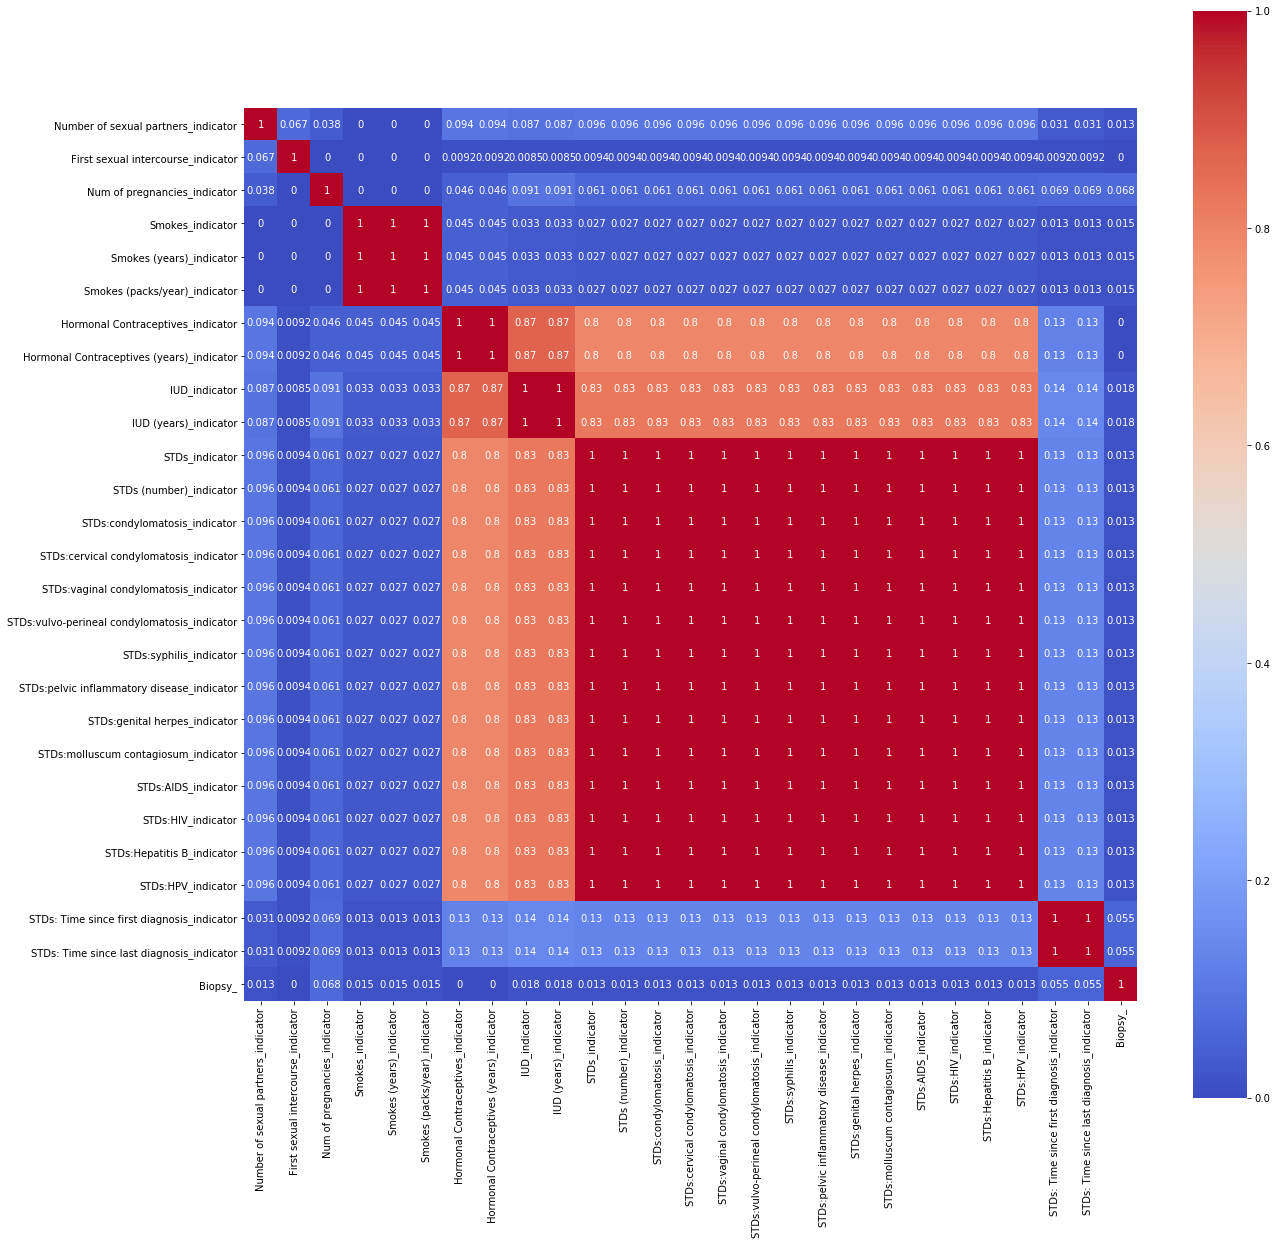

In [12]:
plt.figure(figsize=(20, 20))

sns.heatmap(jaccard_matrix, annot=True, cmap="coolwarm", square=True)

In [13]:
data_with_indicators = pd.concat([data, missing_indicators], axis=1)

In [14]:
data_with_indicators.drop('Biopsy_', axis=1, inplace=True)

In [15]:
data.shape

(835, 33)

In [16]:
data_with_indicators.shape

(835, 59)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("Biopsy", axis=1),
    data["Biopsy"],
    stratify=data["Biopsy"],
    test_size=0.4,
    random_state=42)

In [18]:
X_train_with_indicators, X_test_with_indicators, y_train, y_test = train_test_split(
    data_with_indicators.drop("Biopsy", axis=1),
    data_with_indicators["Biopsy"],
    stratify=data_with_indicators["Biopsy"],
    test_size=0.4,
    random_state=42)

## 1 Base model

In [20]:
pipe = Pipeline([('imputation', SimpleImputer(strategy='most_frequent')),
                 ('classifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1))])

In [21]:
base_rf = pipe.fit(X_train, y_train)

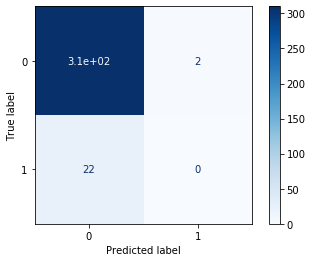

In [23]:
plot_confusion_matrix(base_rf, X_test, y_test, cmap='Blues')

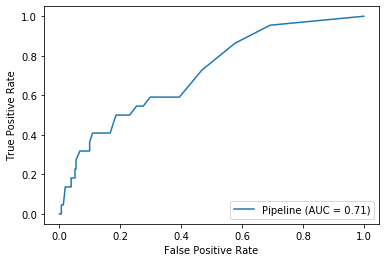

In [47]:
base_roc = plot_roc_curve(base_rf, X_test, y_test)

## 2 Random Forest with missing values indicators

In [25]:
param_grid = { 
    'classifier__n_estimators': [200],
    'classifier__max_features': Integer(1, 10),
    'classifier__max_depth' : Integer(1, 5)
}

In [26]:
pipe = Pipeline([('imputation', SimpleImputer(strategy='most_frequent')),
                 ('classifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1))])

In [27]:
rf_grid = BayesSearchCV(estimator=pipe,
                        search_spaces=param_grid,
                        scoring='roc_auc',
                        n_jobs=-1).fit(X_train_with_indicators, y_train)

In [28]:
rf_best_indicators = rf_grid.best_estimator_

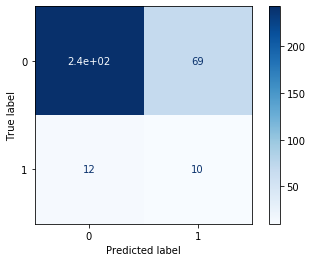

In [30]:
plot_confusion_matrix(rf_best_indicators, X_test_with_indicators, y_test, cmap='Blues')

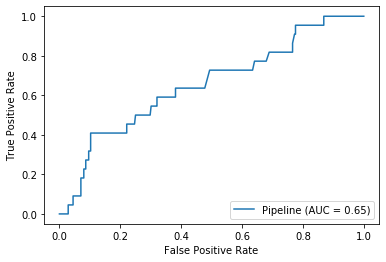

In [60]:
rf_best = plot_roc_curve(rf_best_indicators, X_test_with_indicators, y_test)

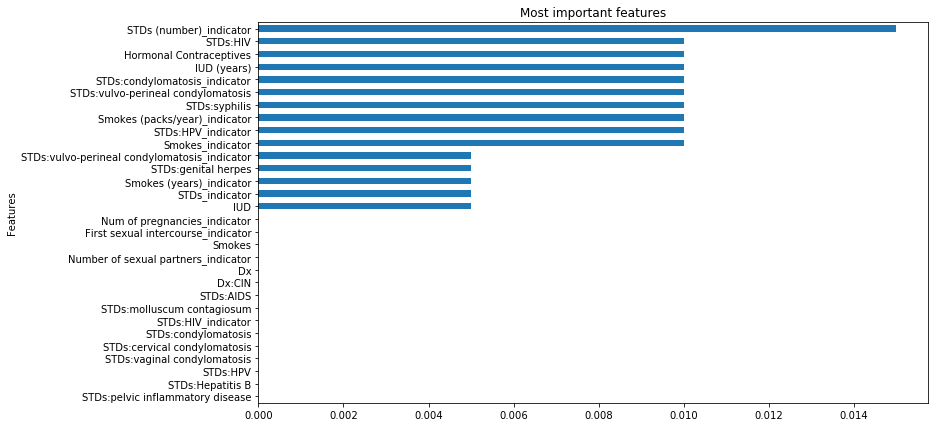

In [71]:
def rf_feat_importance(m, df):
    """
    m - trained Tree-based model
    df - X_train dataset used to train model m
    """
    return pd.DataFrame({'Features'    : df.columns, 
                         'Importance' : m.feature_importances_
                        }).sort_values('Importance', ascending=True)

fi = rf_feat_importance( rf_best_indicators[1], X_train_with_indicators)

def plot_fi(fi):
    return fi.plot('Features', 'Importance', 'barh', figsize=(12,7), legend=False,title="Most important features" )

plot_fi(fi.head(30))

Refitting best model on all training data with more trees causes slight improvements 

In [106]:
rf_best_indicators.set_params(classifier__n_estimators = 10000)

Pipeline(memory=None,
         steps=[('imputation',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=1,
                                        max_features=5, max_leaf_nodes=None,
                                        max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10000, n_jobs=-1,
                   

In [107]:
best_model_refitted = rf_best_indicators.fit(X_train_with_indicators, y_train)

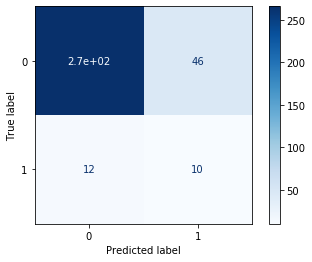

In [108]:
plot_confusion_matrix(best_model_refitted, X_test_with_indicators, y_test, cmap='Blues')

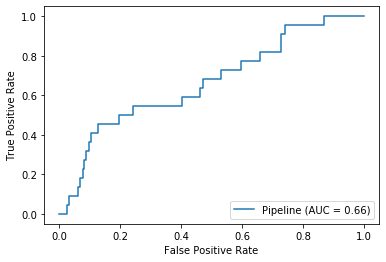

In [109]:
plot_roc_curve(best_model_refitted, X_test_with_indicators, y_test)

## 3 Logistic regression with missing values indicators

In [35]:
pipe = Pipeline([('imputation', SimpleImputer(strategy='most_frequent')),
                 ('classifier', LogisticRegression(solver='saga'))])

In [38]:
param_grid = [{
    'classifier__penalty': ['none', 'l2', 'l1'],
    'classifier__C': np.logspace(0, 4, 10),
    'classifier__class_weight' : ['balanced']
}]

In [39]:
log_reg_grid_indicators = BayesSearchCV(estimator=pipe,
                                        search_spaces=param_grid,
                                        scoring='roc_auc',
                                        n_jobs=-1).fit(X_train_with_indicators, y_train)

In [40]:
log_reg_best_indicators = log_reg_grid_indicators.best_estimator_

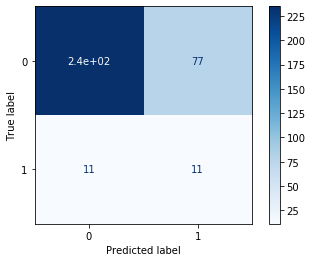

In [42]:
plot_confusion_matrix(log_reg_best_indicators, X_test_with_indicators, y_test, cmap='Blues')

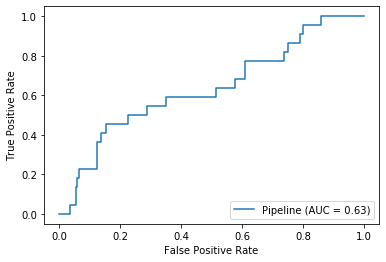

In [59]:
log_reg_roc = metrics.plot_roc_curve(log_reg_best_indicators, X_test_with_indicators, y_test)

## 4 Lasso with upsampling and missing values indicators

In [112]:
pipe = Pipeline([('imputation', SimpleImputer(strategy='most_frequent')),
                 ('upsampling', RandomOverSampler()),
                 ('classifier', LogisticRegression(solver='liblinear'))])

In [113]:
param_grid = [{
    'classifier__penalty': ['l1'],
    'classifier__C': np.logspace(0, 4, 10),
    'classifier__class_weight' : ['balanced']
}]

In [114]:
lasso_grid_upsample_indicators = BayesSearchCV(estimator=pipe,
                                               search_spaces=param_grid,
                                               scoring='roc_auc',
                                               n_jobs=-1).fit(
                                                   X_train_with_indicators,
                                                   y_train)

In [115]:
lasso_best_upsample_indicators = lasso_grid_upsample_indicators.best_estimator_

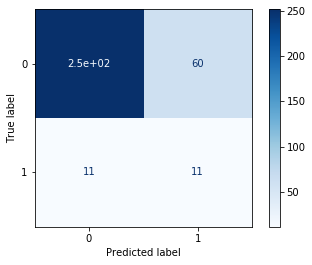

In [116]:
plot_confusion_matrix(lasso_best_upsample_indicators, X_test_with_indicators, y_test, cmap='Blues')

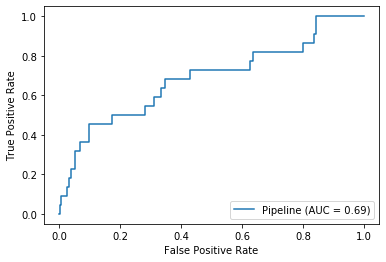

In [117]:
metrics.plot_roc_curve(lasso_best_upsample_indicators, X_test_with_indicators, y_test)

Many coeficcients were reduced to zero, suggesting that they are not predictive.

In [118]:
for col, coeff in zip(X_train_with_indicators.columns, lasso_best_upsample_indicators[2].coef_[0]):
    if coeff == 0:
        print(col, round(coeff, 4))

STDs (number) 0.0
STDs:condylomatosis 0.0
STDs:cervical condylomatosis 0.0
STDs:pelvic inflammatory disease 0.0
STDs:molluscum contagiosum 0.0
STDs:AIDS 0.0
STDs:Hepatitis B 0.0
STDs:HPV 0.0
Dx:Cancer 0.0
Dx 0.0
First sexual intercourse_indicator 0.0
STDs: Time since first diagnosis_indicator 0.0
STDs: Time since last diagnosis_indicator 0.0
